# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x201885) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

c:\python27\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: divide by zero encountered in log


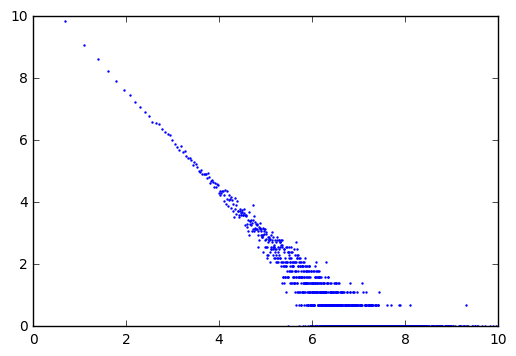

In [6]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    #plt.figure()
    #plt.scatter()
    f = list(np.array(x.sum(axis=0)).reshape(x.shape[1]))
    
    L = sorted(f)
    X = [L[0]]
    Y = [1]
    for i in xrange(1, len(L)):
        if L[i - 1] == L[i]:
            Y[-1] += 1
        else:
            X.append(L[i])
            Y.append(1)
    
    Y = np.log(np.array(Y))
    X = np.log(array(X))
    plt.figure()
    plt.ylim(0, 10)
    plt.xlim(0, 10)
    #pw = map(lambda x: "10^{}".format(x), range(0, 11))
    #plt.yticks(arange(11), pw)
    plt.scatter(X, Y, lw=0, s=3)
    plt.show()
    #for i in L:
        
    return np.array(f)
    #return [0] * x.shape[1]


features_counts = draw_log_hist(X)


Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 10000 пользователей.

In [13]:
X1 = X.tocsc()[:, features_counts > 200].toarray()

In [14]:
print X1.shape

(7199, 23)


Вариант задания генерируется на основании вашего ника в техносфере.

In [15]:
USER_NAME = "g.ruhovich"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [32]:
from scipy.sparse import csr_matrix

def sig(z):
    return 1.0 / (1.0 + np.exp(-z))

sigvec = np.vectorize(sig)
from numpy.linalg import inv
from numpy.linalg import solve
class LogisticRegression():
    def compute_cost(self, X, Y, t, C): 
        J = np.mean(- Y * np.log(sig(np.dot(X, t)) + 1e-15)\
                    - (1 - Y) * np.log(1 - sig(np.dot(X, t)) + 1e-15))\
                    + C / X.shape[0] * (t**2).sum()
        return J
    
    def Gradient (self, X, Y, theta, C):
        gradient = np.sum((sigvec(np.dot(X, theta)) - Y) * X.T, axis = 1)\
            + 2 * theta * C / X.shape[0]
        return gradient
    
    def Hessian(self, X, y, theta, C):
        N = len(y)
        sig = np.array(map(sigvec, np.dot(X, theta.T)))
        res = sig * (np.ones(N) - sig)
        matrix_sum = csr_matrix(np.zeros((theta.shape[0], theta.shape[0])))
        for i in xrange(N):
            matrix_sum += (csr_matrix([X[i]]).T).dot(csr_matrix([X[i]])) * res[i]
            summ = matrix_sum / N
        return summ.toarray() + 2 * C * theta.shape[0]
    
    def __init__(self, C=1):
        self.C = C
    
    def fit(self, X, Y=None):
        alpha = 1e-10
        eps = 1e-5
        t = np.zeros(X.shape[1])
        t[0] = 1
        for i in range(int(1e5)):
            g = self.Gradient(X, Y, t, self.C)
            H = self.Hessian(X, Y, t, self.C)
            #print -inv(H)
            #print type(g), g
            d = linalg.solve(H, -g)
            #d = np.dot(-inv(H),g)
            t_new = t + alpha * d
            delta = np.sum(np.abs(t_new - t))
            print delta
            t = t_new
                
            if delta < eps:
                self.theta = t
                break
        return self
    
    def get_params(self, deep=False):
        return {"C": self.C}
    def predict_proba(self, X):
        prob = sigvec(np.dot(X, self.theta))
        return prob
    
    def predict(self, X):
        return self.predict_proba(X) > 0.5
    
#a = LogisticRegression()
#a.fit(np.array([[0, 1], [1, 2], [2, 3], [3, 4]]), np.array([0, 1, 1, 1]))
#a.fit(np.array([[1, 0], [0, 1], [2, 3], [3, 2]]), np.array([0, 1, 1, 1]))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [33]:
def auroc(y_prob, y_true, step = 0.001):
    spe = []
    sen = []
    area = 0
    for x in xrange(0, int(1 / step)):
        thres = 1 - step * (x - 1)
        y_predict = y_prob >= thres
        
        true_pos = np.sum(np.logical_and(y_predict == 1, y_true == 1))
        false_pos = np.sum(y_predict == 1) - true_pos
        
        true_neg = np.sum(np.logical_and(y_predict == 0, y_true == 0))
        false_neg = (y_predict == 0).sum() - true_neg
        if true_pos > 0:
            sen.append(true_pos / (true_pos + false_neg))
        else:
            sen.append(0)
            
        if false_pos > 0:
            spe.append( false_pos / (false_pos + true_neg))
        else:
            spe.append(0)
            
        if x > 0:
            area += (one_minus_specificity_arr[x] - one_minus_specificity_arr[x - 1]) *\
                ( (sensitivity_arr[x] - sensitivity_arr[x - 1]) / 2 + sensitivity_arr[x - 1])
        
    return  sensitivity_arr, one_minus_specificity_arr, area

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [34]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    mean = []
    std = []
    s = []
    for i in C:
        model = LogisticRegression(i)
        score = cv.cross_val_score(model, X, Y, cv = 5, scoring="accuracy")
        mean.append(score.mean())
        std.append(score.std())
        s.append((mean[-1] -1) ** 2 + std[-1] ** 2)
    return s.index(min(s))

index = select_reg_parameter(C, X1, Y)
print index


5.67621126445e-06
5.27091967795e-06
5.15843027213e-06
5.27684836123e-06
5.38037799346e-06
3.32894354932e-06
3.07691234337e-06
3.03104011827e-06
3.23305079602e-06
3.11260982418e-06
3.04294953523e-06
2.81064577605e-06
2.76973560395e-06
2.98116905053e-06
2.83037649661e-06
3.00967852131e-06
2.77983335156e-06
2.73969068205e-06
2.95182885401e-06
2.79744191993e-06
3.00629966303e-06
2.77685137838e-06
2.73666694364e-06
2.94884919178e-06
2.79409602202e-06
3.00598796848e-06
2.77657935986e-06
2.73639093528e-06
2.94857871449e-06
2.79378710766e-06
3.00622424039e-06
2.77681874251e-06
2.73663197972e-06
2.94883147613e-06
2.79401856523e-06
3.00892233585e-06
2.77950857374e-06
2.73934258672e-06
2.95165489428e-06
2.79666525494e-06
0


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

5.16137154878e-06
Area under the ROC curve : 0.485187


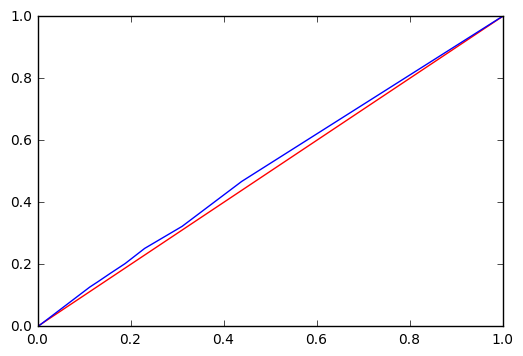

In [41]:
from sklearn.cross_validation import train_test_split
def classify(X, Y, test_size, C):
    model = LogisticRegression(C)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)
    Y_test_pred = model.fit(X_train, Y_train).predict_proba(X_test)
    tpr, fpr, roc_auc = auroc(Y_test_pred, Y_test)
    return tpr, fpr, roc_auc, model

tpr, fpr, roc_auc, model = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    plt.figure()
    plt.plot([0, 1], [0, 1], color="red")
    plt.plot(tpr, fpr, color="blue")
    
    # Your code here
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [45]:
test_users = df_users_ex["uid"].values
ix = np.in1d(users, test_users).reshape(users.shape)
X_ex = X_dataset[np.where(ix)]
X1_ex = X_ex[:,features_counts > 200]
X1_ex = X1_ex.toarray()

In [46]:
predicted = model.predict_proba(X1_ex)
df_users_ex.columns = [u'uid', u'cls']
df_users_ex['cls'] = predicted
df_users_ex.to_csv(path_or_buf = "result.csv", index = False)